## Multi-Output Machine Learning Models for Type 2 Diabetes

### Data Preprocessing

In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset
full_data_path = 'diabetes_data_upload.csv'  # Update this path as needed
df = pd.read_csv(full_data_path)

# Displaying first few rows of the dataset
print(df.head())

   Age Gender Polyuria Polydipsia sudden weight loss weakness Polyphagia  \
0   40   Male       No        Yes                 No      Yes         No   
1   58   Male       No         No                 No      Yes         No   
2   41   Male      Yes         No                 No      Yes        Yes   
3   45   Male       No         No                Yes      Yes        Yes   
4   60   Male      Yes        Yes                Yes      Yes        Yes   

  Genital thrush visual blurring Itching Irritability delayed healing  \
0             No              No     Yes           No             Yes   
1             No             Yes      No           No              No   
2             No              No     Yes           No             Yes   
3            Yes              No     Yes           No             Yes   
4             No             Yes     Yes          Yes             Yes   

  partial paresis muscle stiffness Alopecia Obesity     class  
0              No              Yes      

              Age
count  520.000000
mean    48.028846
std     12.151466
min     16.000000
25%     39.000000
50%     47.500000
75%     57.000000
max     90.000000


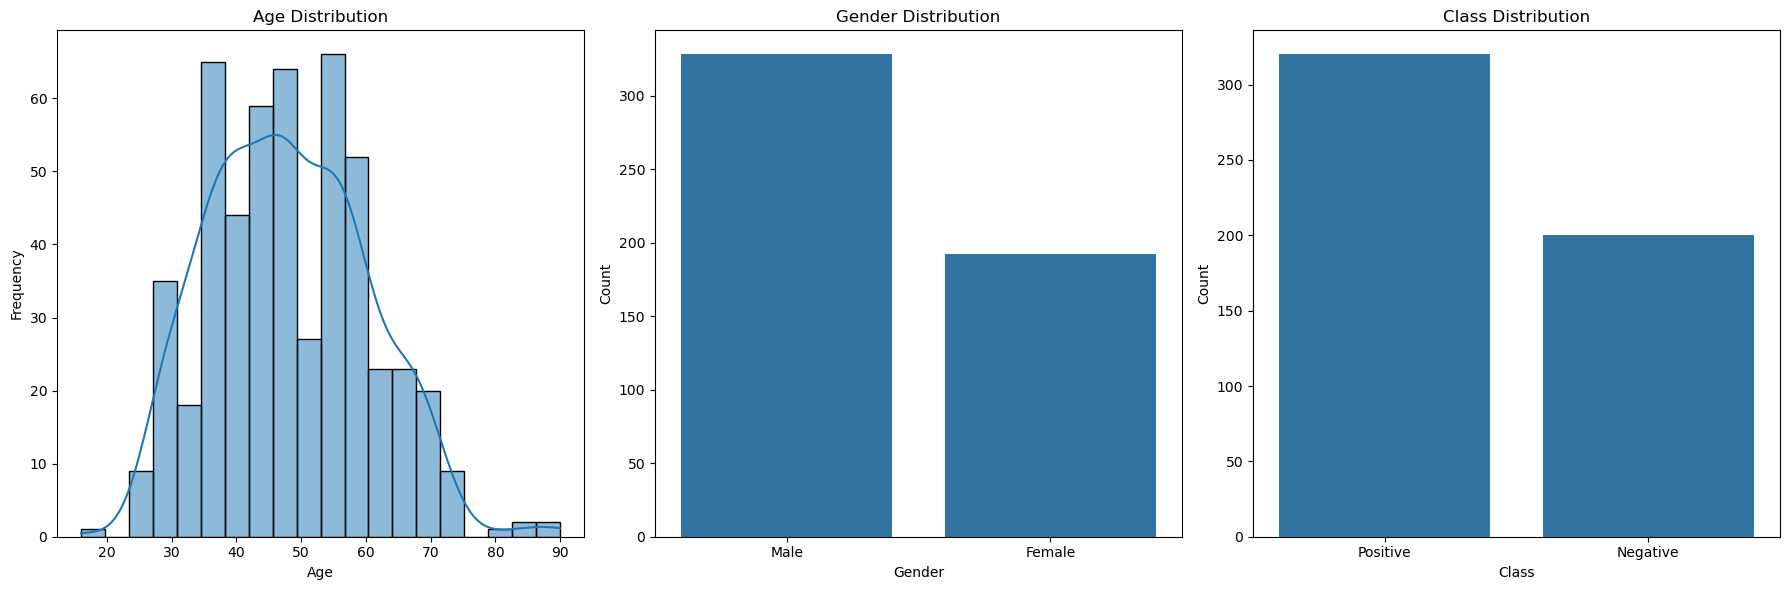

In [156]:
#Basic statistics
print(df.describe())

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Age Distribution
sns.histplot(df['Age'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Gender Distribution
sns.countplot(x='Gender', data=df, ax=axes[1])
axes[1].set_title('Gender Distribution')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')

# Existing Class Distribution
sns.countplot(x='class', data=df, ax=axes[2])
axes[2].set_title('Class Distribution')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')

# layout
plt.tight_layout()
plt.show()

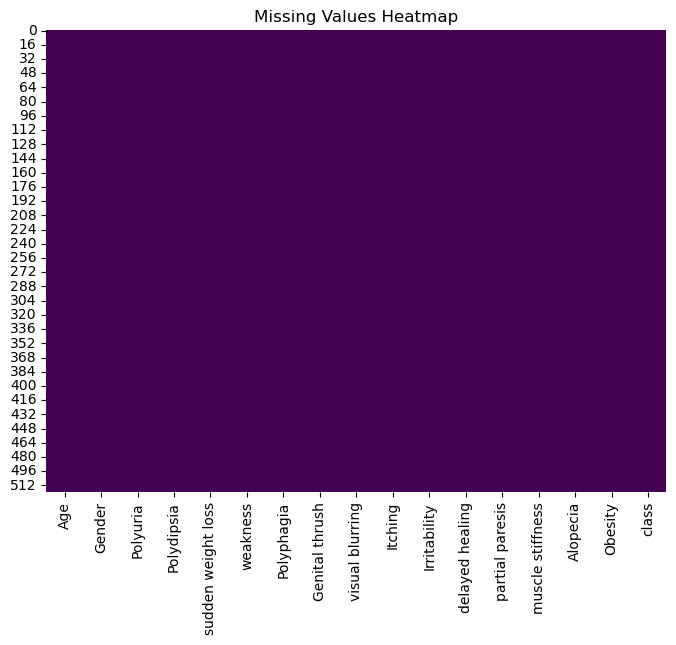

In [157]:
#Heatmap for missing values
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [158]:
from sklearn.preprocessing import LabelEncoder

# Converting categorical variables to numerical
df.replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0}, inplace=True)

# Creating target variables for each complication based on individual feature values
df['Neuropathy'] = (df['weakness'] | df['partial paresis'] | df['muscle stiffness'] | df['delayed healing']).astype(int)
df['Nephropathy'] = (df['weakness'] | df['Obesity'] | df['sudden weight loss'] | df['Polydipsia']).astype(int)
df['Ketoacidosis'] = (df['Polyuria'] | df['Polydipsia'] | df['sudden weight loss'] | df['weakness']).astype(int)

# Droping original 'class' column as we now have separate target variables
df.drop(columns=['class'], inplace=True)

# Displaying the preprocessed data
print(df.head())

   Age  Gender  Polyuria  Polydipsia  sudden weight loss  weakness  \
0   40       1         0           1                   0         1   
1   58       1         0           0                   0         1   
2   41       1         1           0                   0         1   
3   45       1         0           0                   1         1   
4   60       1         1           1                   1         1   

   Polyphagia  Genital thrush  visual blurring  Itching  Irritability  \
0           0               0                0        1             0   
1           0               0                1        0             0   
2           1               0                0        1             0   
3           1               1                0        1             0   
4           1               0                1        1             1   

   delayed healing  partial paresis  muscle stiffness  Alopecia  Obesity  \
0                1                0                 1         1 

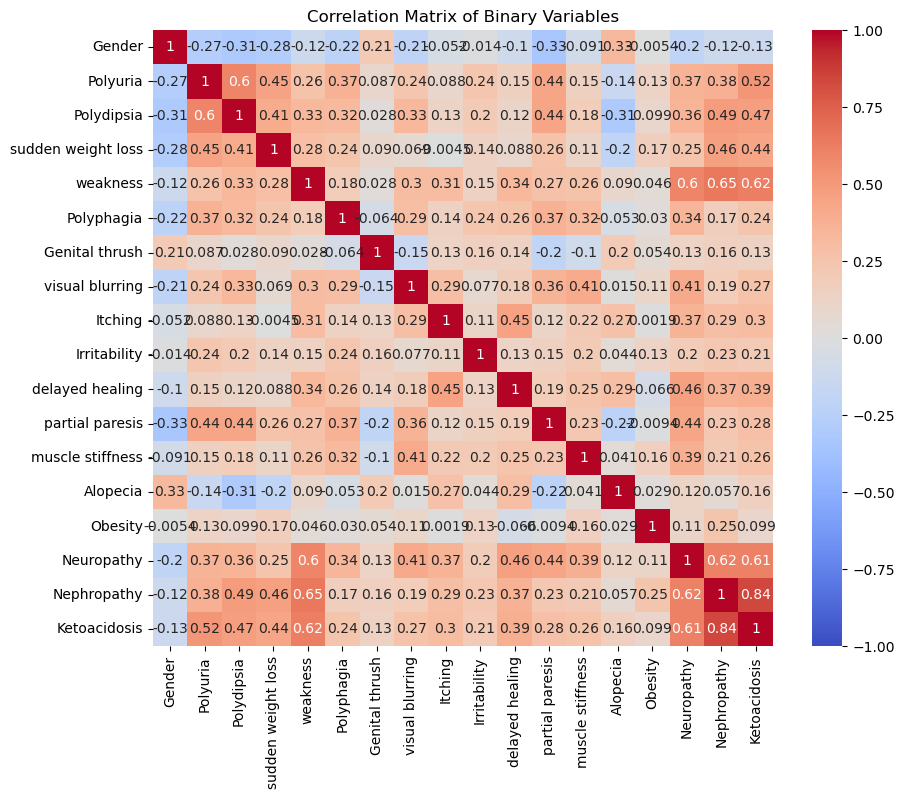

In [161]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Excluinge 'age' column to focus only on binary variables
binary_df = df.drop(columns=['Age'])

# Correlation matrix for binary variables
correlation_matrix = binary_df.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Binary Variables')
plt.show()

### Feature Seperation, Train Test Split, Class IMbalance

In [162]:
# Separate features and target variables
X = df.drop(columns=['Neuropathy', 'Nephropathy', 'Ketoacidosis'])
y = df[['Neuropathy', 'Nephropathy', 'Ketoacidosis']]

In [163]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (416, 16)
X_test shape: (104, 16)
y_train shape: (416, 3)
y_test shape: (104, 3)


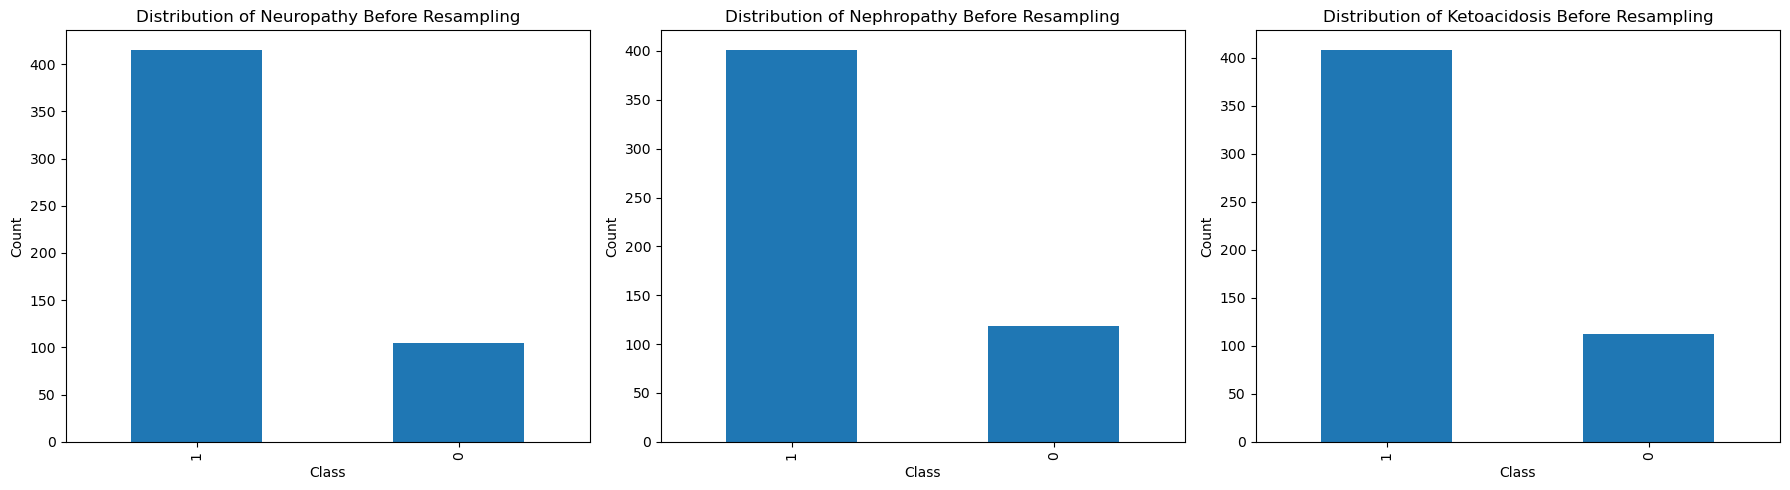

In [164]:
# Distribution of the target variables before resampling
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

class_names = ['Neuropathy', 'Nephropathy', 'Ketoacidosis']
for i, col in enumerate(class_names):
    y[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribution of {col} Before Resampling')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

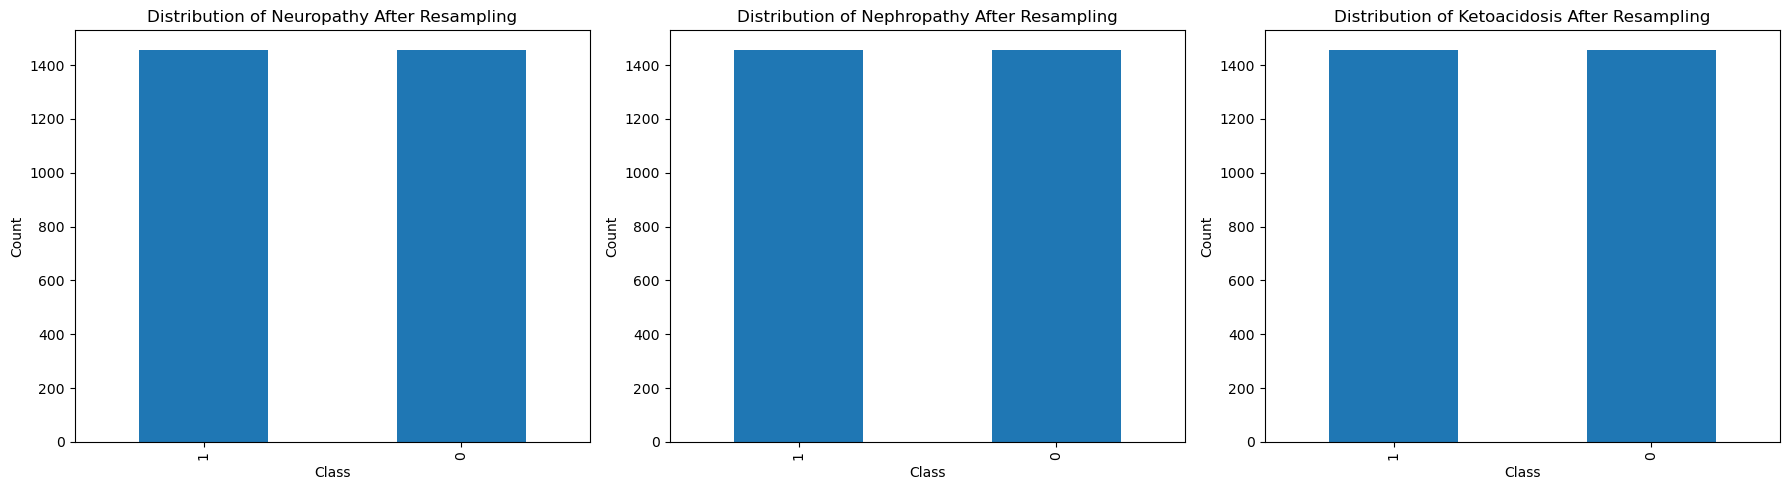

In [165]:
from imblearn.over_sampling import RandomOverSampler

# Initialize
oversampler = RandomOverSampler(random_state=42)

# Concatenating the target variables to treat them as a single entity for resampling
y_combined = y.apply(lambda row: ''.join(row.astype(str)), axis=1)

# Resampling the combined target
X_resampled, y_combined_resampled = oversampler.fit_resample(X, y_combined)

# Spliting the combined target back into separate target variables
y_resampled = pd.DataFrame([list(map(int, x)) for x in y_combined_resampled], columns=y.columns)

# New distribution of the target variables after resampling
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(y.columns):
    y_resampled[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribution of {col} After Resampling')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Model Development and Evaluation

In [166]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Classifiers
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# Multi-Output Classifiers
multi_rf = MultiOutputClassifier(rf, n_jobs=-1)
multi_gb = MultiOutputClassifier(gb, n_jobs=-1)
multi_xgb = MultiOutputClassifier(xgb, n_jobs=-1)

# Fit the models on the resampled training data
multi_rf.fit(X_resampled, y_resampled)
multi_gb.fit(X_resampled, y_resampled)
multi_xgb.fit(X_resampled, y_resampled)

# Predict on Test Data
y_pred_rf = multi_rf.predict(X_test)
y_pred_gb = multi_gb.predict(X_test)
y_pred_xgb = multi_xgb.predict(X_test)

# Evaluate the models
print("RandomForestClassifier Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=y_test.columns))
print("GradientBoostingClassifier Classification Report:\n", classification_report(y_test, y_pred_gb, target_names=y_test.columns))
print("XGBClassifier Classification Report:\n", classification_report(y_test, y_pred_xgb, target_names=y_test.columns))

RandomForestClassifier Classification Report:
               precision    recall  f1-score   support

  Neuropathy       1.00      1.00      1.00        84
 Nephropathy       1.00      1.00      1.00        81
Ketoacidosis       1.00      1.00      1.00        83

   micro avg       1.00      1.00      1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248
 samples avg       0.87      0.87      0.87       248

GradientBoostingClassifier Classification Report:
               precision    recall  f1-score   support

  Neuropathy       1.00      1.00      1.00        84
 Nephropathy       1.00      1.00      1.00        81
Ketoacidosis       1.00      1.00      1.00        83

   micro avg       1.00      1.00      1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248
 samples avg       0.87      0.87      0.87       248

XGBClassifier Classification Rep

C:\Users\raksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raksh\anaconda3\lib\site-packages\sklearn\metrics\_cla

In [167]:
from sklearn.model_selection import cross_val_score

# Cross-validation scores for the models
cv_scores_rf = cross_val_score(multi_rf, X_resampled, y_resampled, cv=5)
cv_scores_gb = cross_val_score(multi_gb, X_resampled, y_resampled, cv=5)
cv_scores_xgb = cross_val_score(multi_xgb, X_resampled, y_resampled, cv=5)

mean_cv_score_rf = np.mean(cv_scores_rf)
mean_cv_score_gb = np.mean(cv_scores_gb)
mean_cv_score_xgb = np.mean(cv_scores_xgb)

print("Mean Cross-Validation Score - Random Forest:", mean_cv_score_rf)
print("Mean Cross-Validation Score - Gradient Boosting:", mean_cv_score_gb)
print("Mean Cross-Validation Score - XGBoost:", mean_cv_score_xgb)

# The best model based on cross-validation scores
best_model_name = ''
best_model = None
best_score = max(mean_cv_score_rf, mean_cv_score_gb, mean_cv_score_xgb)

if best_score == mean_cv_score_rf:
    best_model_name = 'Random Forest'
    best_model = multi_rf
elif best_score == mean_cv_score_gb:
    best_model_name = 'Gradient Boosting'
    best_model = multi_gb
else:
    best_model_name = 'XGBoost'
    best_model = multi_xgb

print(f"Best Model: {best_model_name} with a Cross-Validation Score of {best_score:.4f}")

Mean Cross-Validation Score - Random Forest: 0.9320754716981131
Mean Cross-Validation Score - Gradient Boosting: 0.9626072041166381
Mean Cross-Validation Score - XGBoost: 0.9626072041166381
Best Model: Gradient Boosting with a Cross-Validation Score of 0.9626


In [168]:
from sklearn.model_selection import GridSearchCV

# Parameter grids for each model
param_grids = {
    'Random Forest': {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [None, 10, 20],
        'estimator__min_samples_split': [2, 5, 10],
        'estimator__min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'estimator__n_estimators': [100, 200, 300],
        'estimator__learning_rate': [0.01, 0.1, 1.0],
        'estimator__max_depth': [3, 4, 5],
        'estimator__subsample': [0.8, 0.9, 1.0]
    },
    'XGBoost': {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__learning_rate': [0.01, 0.1, 0.2],
        'estimator__max_depth': [3, 5, 7]
    }
}

# MultiOutput Classifiers
multi_rf = MultiOutputClassifier(RandomForestClassifier(random_state=42), n_jobs=-1)
multi_gb = MultiOutputClassifier(GradientBoostingClassifier(random_state=42), n_jobs=-1)
multi_xgb = MultiOutputClassifier(XGBClassifier(random_state=42), n_jobs=-1)

# Create a dictionary to store the grid search results
grid_searches = {}

# GridSearchCV for each model
for model_name, clf, param_grid in zip(
    ['Random Forest', 'Gradient Boosting', 'XGBoost'], 
    [multi_rf, multi_gb, multi_xgb], 
    [param_grids['Random Forest'], param_grids['Gradient Boosting'], param_grids['XGBoost']]
):
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_resampled, y_resampled)
    grid_searches[model_name] = grid_search
    print(f"{model_name} Best Parameters:", grid_search.best_params_)
    print(f"{model_name} Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Random Forest Best Parameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Random Forest Best Score: 0.9368782161234991
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Gradient Boosting Best Parameters: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 200, 'estimator__subsample': 0.8}
Gradient Boosting Best Score: 0.9626072041166381
Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost Best Parameters: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 200}
XGBoost Best Score: 0.9626072041166381


### Best Model Evaluation

C:\Users\raksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost Classification Report:
               precision    recall  f1-score   support

  Neuropathy       1.00      0.90      0.95        84
 Nephropathy       1.00      1.00      1.00        81
Ketoacidosis       1.00      1.00      1.00        83

   micro avg       1.00      0.97      0.98       248
   macro avg       1.00      0.97      0.98       248
weighted avg       1.00      0.97      0.98       248
 samples avg       0.87      0.84      0.85       248



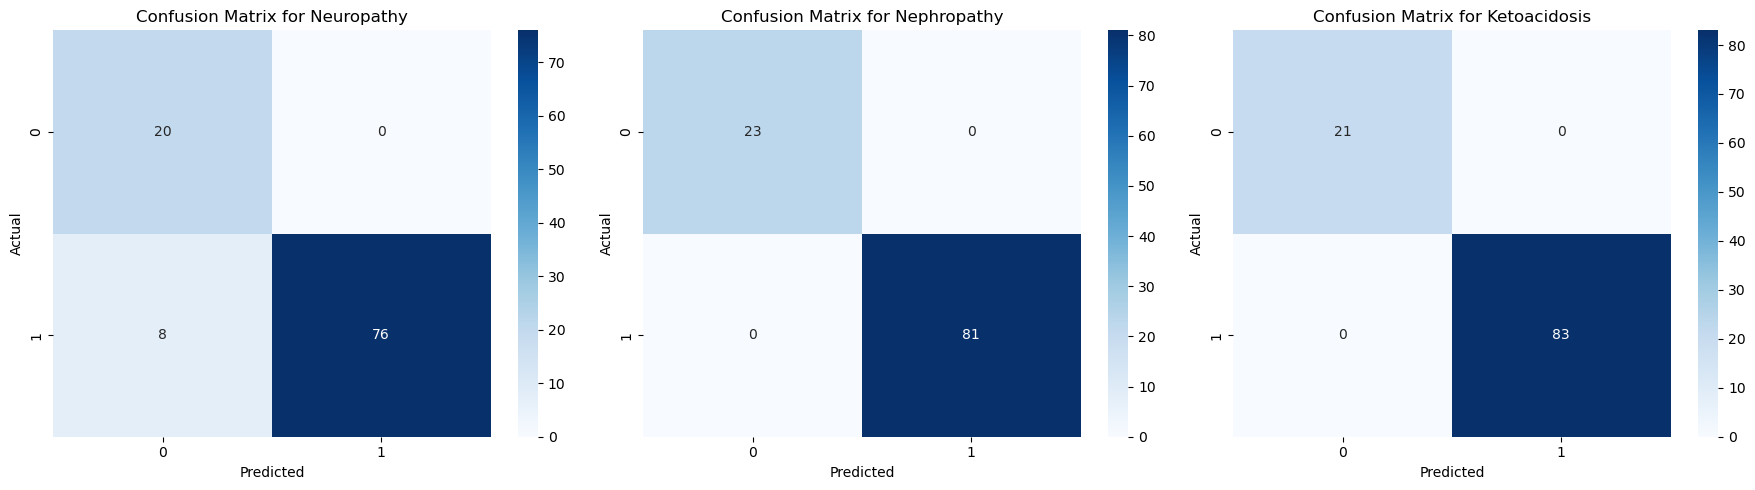

In [169]:
# Best parameter for XG Boost to take further
best_xgb = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=200,
    random_state=42
)
multi_xgb_best = MultiOutputClassifier(best_xgb, n_jobs=-1)

# Fit the model on the resampled training data
multi_xgb_best.fit(X_resampled, y_resampled)

# Predict on Test Data
y_pred_xgb = multi_xgb_best.predict(X_test)

# Generate and print classification report
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb, target_names=y_test.columns))

# Function to plot confusion matrix for each class
def plot_confusion_matrices(y_true, y_pred, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(1, num_classes, figsize=(18, 5))
    if num_classes == 1:
        axes = [axes]  # Ensure axes is iterable if there is only one class
    
    for i, col in enumerate(class_names):
        cm = confusion_matrix(y_true[col], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt="d", ax=axes[i], cmap="Blues")
        axes[i].set_title(f'Confusion Matrix for {col}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

# Plot the confusion matrices for the best model
plot_confusion_matrices(y_test, y_pred_xgb, y_test.columns)

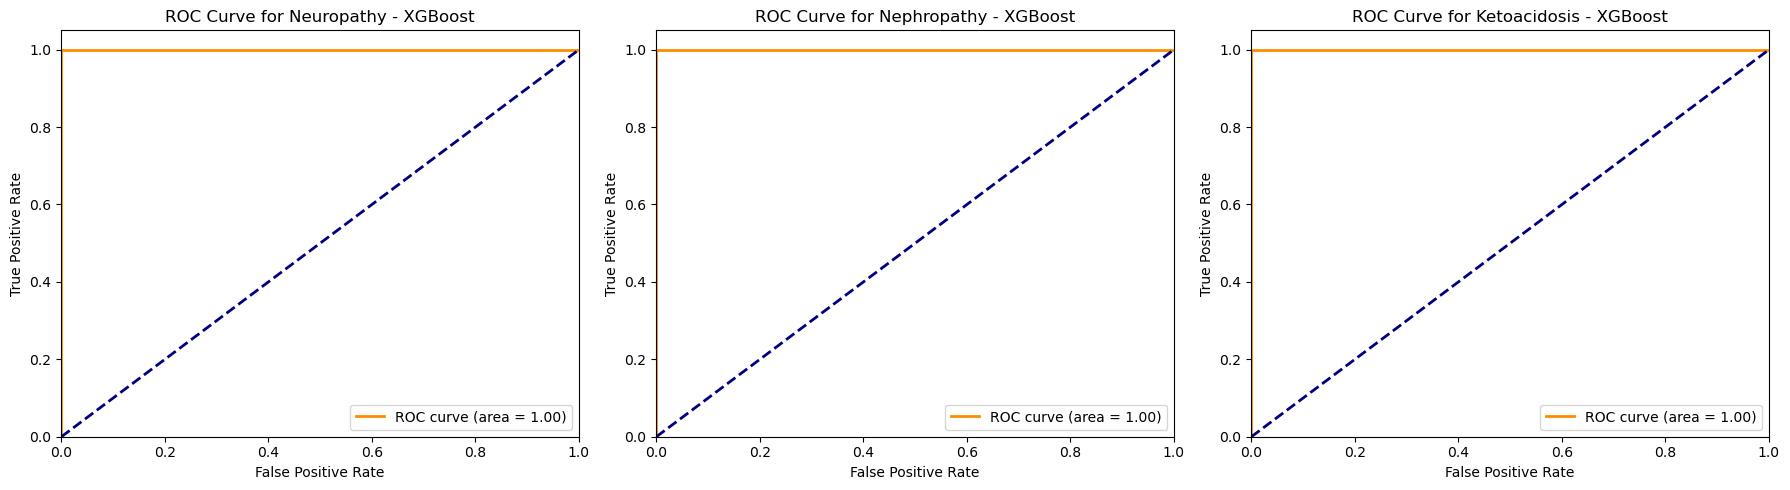

In [170]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves_multi_output(y_test, y_pred_proba, model_name):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    complications = y_test.columns  # Target columns are the complications

    for i, complication in enumerate(complications):
        # Computing ROC curve and ROC area for each class
        fpr, tpr, _ = roc_curve(y_test[complication], y_pred_proba[i][:, 1])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        axes[i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].set_title(f'ROC Curve for {complication} - {model_name}')
        axes[i].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Predicting probabilities using the best XGBoost model
y_pred_proba_xgb = multi_xgb_best.predict_proba(X_test)

# Ploting ROC curves for the XGBoost model
plot_roc_curves_multi_output(y_test, y_pred_proba_xgb, 'XGBoost')

In [171]:
from sklearn.metrics import classification_report

# Predicting on training data
y_pred_train_xgb = multi_xgb_best.predict(X_resampled)

# Predicting on test data
y_pred_test_xgb = multi_xgb_best.predict(X_test)

# Predicting probabilities for ROC curves
y_pred_proba_train_xgb = multi_xgb_best.predict_proba(X_resampled)
y_pred_proba_test_xgb = multi_xgb_best.predict_proba(X_test)

# Generating classification report for training data
print("Classification Report for Training Data:\n", classification_report(y_resampled, y_pred_train_xgb, target_names=y_resampled.columns))

# Generating classification report for test data
print("Classification Report for Test Data:\n", classification_report(y_test, y_pred_test_xgb, target_names=y_test.columns))


Classification Report for Training Data:
               precision    recall  f1-score   support

  Neuropathy       1.00      0.97      0.99      1456
 Nephropathy       1.00      1.00      1.00      1456
Ketoacidosis       1.00      1.00      1.00      1456

   micro avg       1.00      0.99      1.00      4368
   macro avg       1.00      0.99      1.00      4368
weighted avg       1.00      0.99      1.00      4368
 samples avg       0.88      0.87      0.87      4368

Classification Report for Test Data:
               precision    recall  f1-score   support

  Neuropathy       1.00      0.90      0.95        84
 Nephropathy       1.00      1.00      1.00        81
Ketoacidosis       1.00      1.00      1.00        83

   micro avg       1.00      0.97      0.98       248
   macro avg       1.00      0.97      0.98       248
weighted avg       1.00      0.97      0.98       248
 samples avg       0.87      0.84      0.85       248



C:\Users\raksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raksh\anaconda3\lib\site-packages\sklearn\metrics\_cla

In [172]:
from sklearn.metrics import accuracy_score

# Compute accuracy for training data
accuracy_train = accuracy_score(y_resampled, y_pred_train_xgb)

# Compute accuracy for test data
accuracy_test = accuracy_score(y_test, y_pred_test_xgb)

print(f"Accuracy for Training Data: {accuracy_train:.2f}")
print(f"Accuracy for Test Data: {accuracy_test:.2f}")

Accuracy for Training Data: 0.99
Accuracy for Test Data: 0.92


### Model Validation and Performance

In [173]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Custom scoring function for multi-output classification
def multioutput_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Perform k-fold cross-validation
cv_scores = cross_val_score(multi_xgb_best, X_resampled, y_resampled, cv=5, scoring=make_scorer(multioutput_accuracy), n_jobs=-1)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.2f}")
print(f"Standard Deviation of Cross-Validation Scores: {cv_scores.std():.2f}")

Cross-Validation Scores: [0.81303602 1.         1.         1.         1.        ]
Mean Cross-Validation Score: 0.96
Standard Deviation of Cross-Validation Scores: 0.07


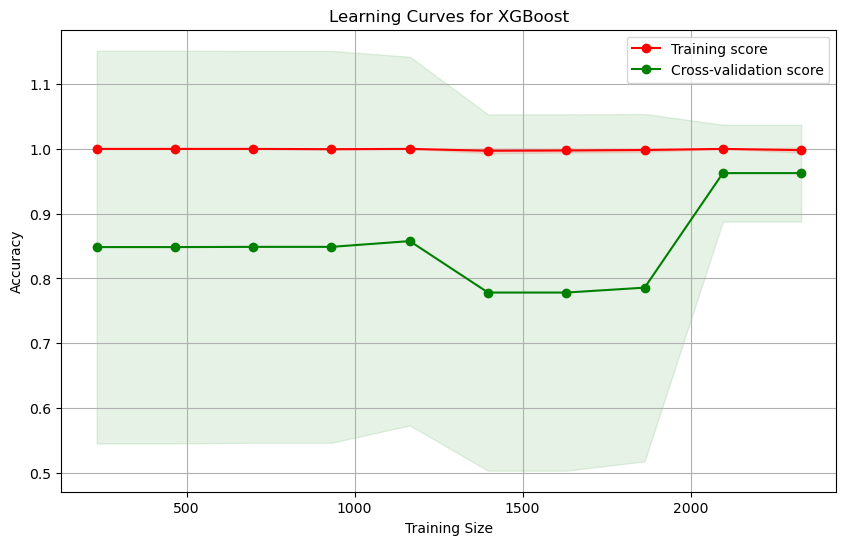

Learning Curve:
Training scores: [1.         1.         1.         0.99957035 1.         0.99713672
 0.99754601 0.99828234 1.         0.99811078]
Test scores: [0.8483705  0.8483705  0.84871355 0.84871355 0.85763293 0.77817368
 0.77817368 0.78572085 0.9626072  0.9626072 ]


In [174]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, accuracy_score

# Custom scoring function for multi-output classification
def multioutput_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    multi_xgb_best, 
    X_resampled, 
    y_resampled, 
    cv=5, 
    scoring=make_scorer(multioutput_accuracy), 
    n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)  # Training sizes from 10% to 100%
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')

# Plot the std deviation as shaded regions
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')

plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves for XGBoost')
plt.legend(loc='best')
plt.grid(True)
plt.show()

    # Print additional information
print("Learning Curve:")
print(f"Training scores: {train_mean}")
print(f"Test scores: {test_mean}")

### Model Interpretabilit and Feature Importance

type                   cover      gain  total_cover  total_gain    weight  \
feature                                                                     
Polyuria            0.350333  0.517616     0.445262    0.611488  0.333333   
Obesity             0.350126  0.395537     0.427817    0.473943  0.315457   
partial paresis     0.269636  0.308765     0.392552    0.390649  0.290323   
delayed healing     0.194193  0.251898     0.294140    0.331578  0.302053   
sudden weight loss  0.234669  0.224046     0.224636    0.203858  0.249219   
muscle stiffness    0.184516  0.229160     0.203507    0.219646  0.219941   
weakness            0.181308  0.127481     0.128028    0.084761  0.168081   
Polydipsia          0.147968  0.115191     0.124469    0.098158  0.168473   
visual blurring     0.194029  0.120915     0.029960    0.016225  0.030792   

type                     avg  
feature                       
Polyuria            0.451606  
Obesity             0.392576  
partial paresis     0.330385

C:\Users\raksh\AppData\Local\Temp\ipykernel_1224\526827248.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg', y=feature_importance_df.index, data=feature_importance_df.reset_index(), palette='viridis')


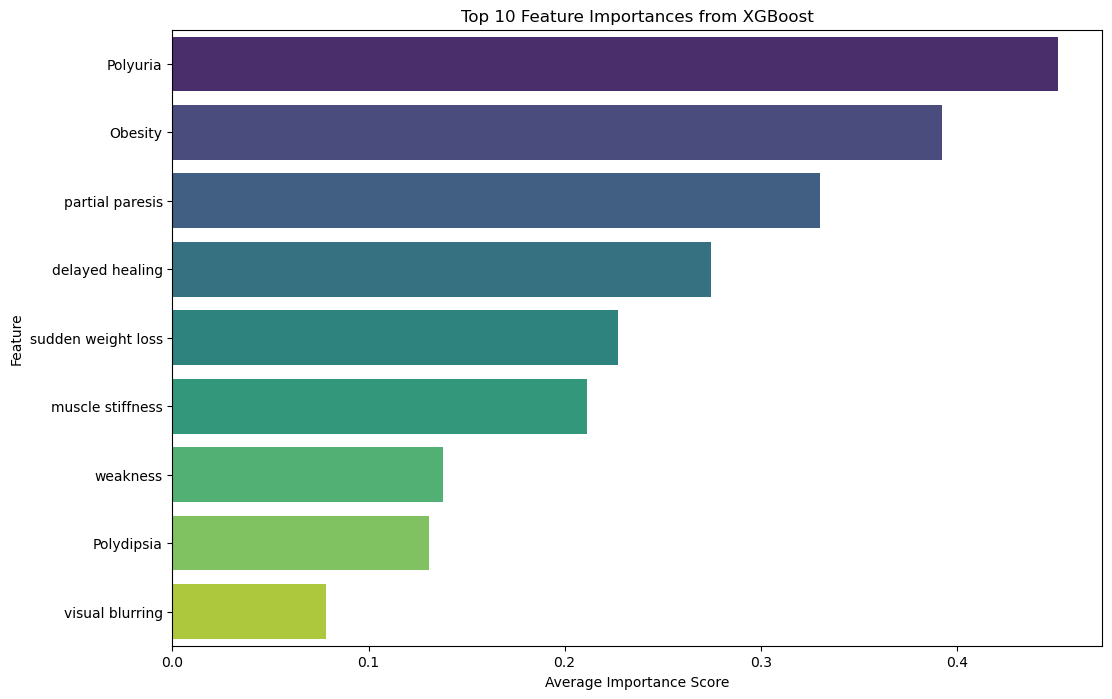

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def simplified_feat_imp(multi_output_model, n=None):
    imp_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    df_imp = pd.DataFrame(columns=['type', 'feature', 'importance', 'target'])
    
    # Extracting feature importances for classifier
    for i, estimator in enumerate(multi_output_model.estimators_):
        model = estimator
        for importance in imp_type:
            FI = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type=importance), orient='index', columns=['importance']).reset_index().sort_values('importance', ascending=False)
            FI.columns = ['feature', 'importance']
            FI['importance'] = FI['importance'] / sum(FI['importance'])
            FI.insert(0, 'type', importance)
            FI['target'] = f"Target_{i}"  # Adding target label for each classifier
            df_imp = pd.concat([df_imp, FI], ignore_index=True)  # Combine results
    
    # Pivot and compute average importance
    df_imp = df_imp.pivot_table(index=['feature'], columns='type', values='importance', aggfunc='mean').fillna(0)
    df_imp['avg'] = df_imp.mean(axis=1)  # Average importance score
    df_imp = df_imp.sort_values('avg', ascending=False)  # Sort by average importance

    if n:
        return df_imp.head(n)  # Return top n features
    else:
        return df_imp

# Simplified feature importance
feature_importance_df = simplified_feat_imp(multi_xgb_best, n=10)

# Printing feature importances
print(feature_importance_df)

# Ploting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='avg', y=feature_importance_df.index, data=feature_importance_df.reset_index(), palette='viridis')

plt.title('Top 10 Feature Importances from XGBoost')
plt.xlabel('Average Importance Score')
plt.ylabel('Feature')
plt.show()

<Figure size 1400x800 with 0 Axes>

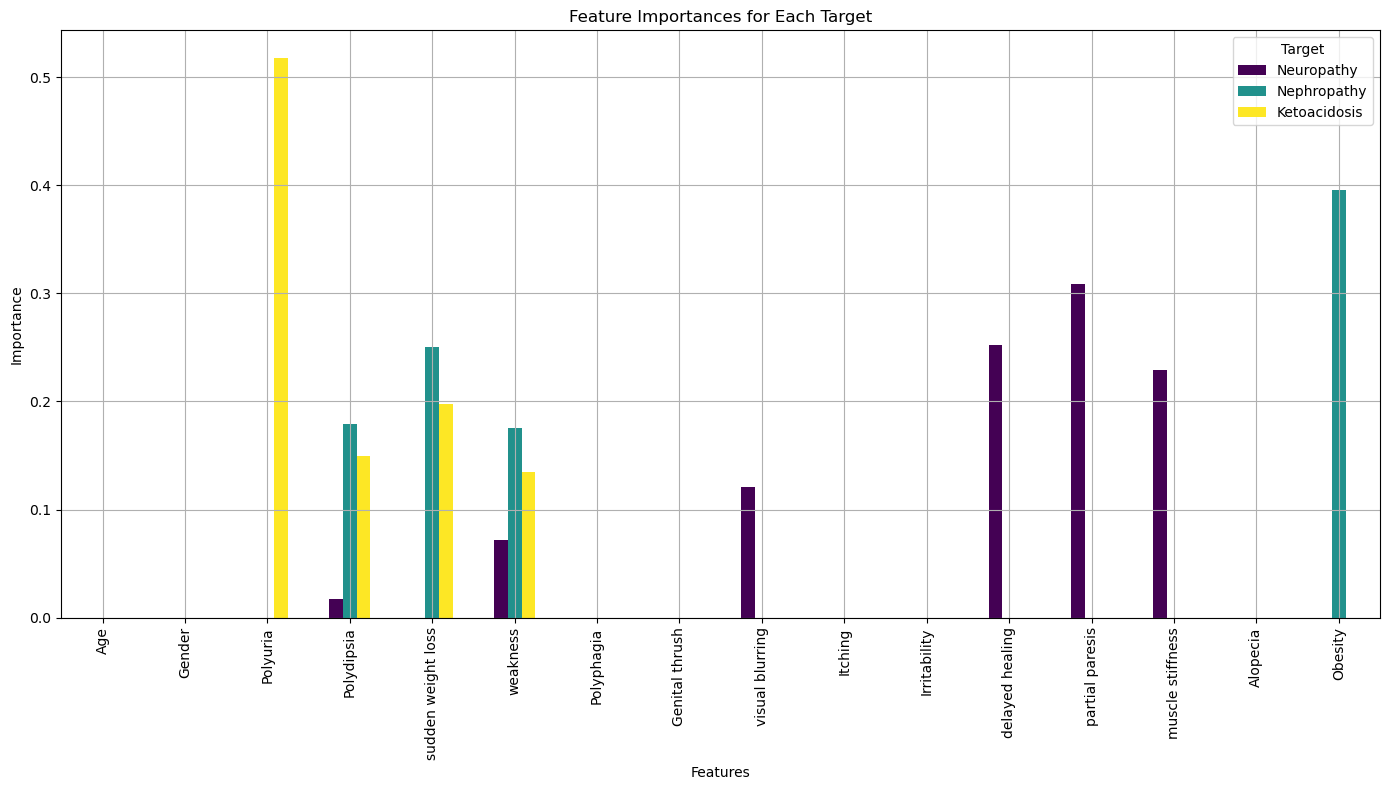

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(X_resampled, pd.DataFrame):
    feature_names = X_resampled.columns
else:
    
    feature_names = ['feature1', 'feature2', 'feature3']  # Replace with actual feature names

# DataFrame to hold feature importances for each target
feature_importances_df = pd.DataFrame()

for idx, target_name in enumerate(class_names):
    base_classifier = multi_xgb_best.estimators_[idx]
    if hasattr(base_classifier, 'feature_importances_'):
        feature_importances = base_classifier.feature_importances_
    else:
        raise AttributeError(f"Base classifier for target {target_name} does not have 'feature_importances_' attribute")

    feature_importances_df[target_name] = feature_importances

# Adding feature names to the DataFrame
feature_importances_df.index = feature_names

# Ploting feature importances for each target
plt.figure(figsize=(14, 8))
feature_importances_df.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Feature Importances for Each Target')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend(title='Target')
plt.grid(True)
plt.tight_layout()
plt.show()

True Label: [1 0 1], Prediction: [1 0 1]

Explanation for the instance:
[('0.00 < partial paresis <= 1.00', 0.4568799886143507), ('delayed healing > 0.00', 0.44445514898047966), ('muscle stiffness > 0.00', 0.3742921346629022), ('weakness <= 0.00', -0.15241670583556527), ('0.00 < visual blurring <= 1.00', 0.026060825600253718), ('Polydipsia <= 0.00', 0.019325779620675342), ('0.00 < Polyuria <= 1.00', 0.015358124772609609), ('sudden weight loss <= 0.00', 0.012448854304538052), ('Genital thrush <= 0.00', 0.009157017998862474), ('0.00 < Gender <= 1.00', 0.006266276801507306)]


C:\Users\raksh\anaconda3\lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


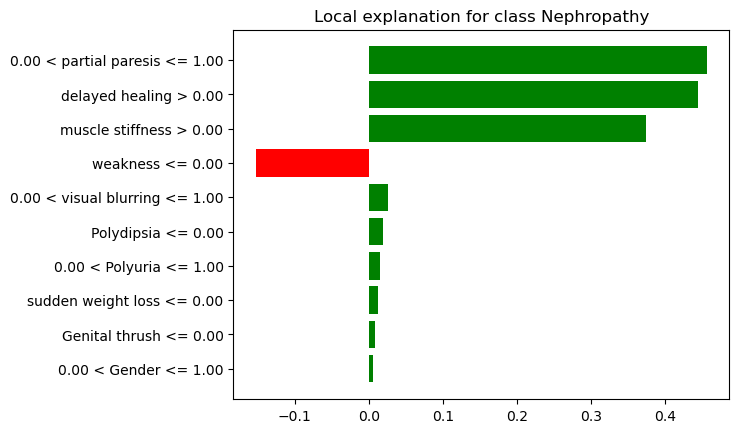

In [177]:
from lime.lime_tabular import LimeTabularExplainer

# DataFrames to NumPy Arrays
X_train_np = X_resampled.to_numpy()  # Training data
X_test_np = X_test.to_numpy()        # Test data

feature_names = X_resampled.columns.tolist()

explainer = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=['Neuropathy', 'Nephropathy', 'Ketoacidosis'],
    mode='classification'
)

# Prediction function for LIME
def predict_proba_fn(data):
    # Get predictions from the best estimator
    predictions = multi_xgb_best.predict_proba(data)
    # Concatenate predictions into a single array for LIME
    return np.concatenate(predictions, axis=1)

# Single prediction
def explain_prediction(index):
    instance = X_test_np[index]
    true_label = y_test.iloc[index]
    prediction = multi_xgb_best.predict([instance])[0]
    print(f"True Label: {true_label.values}, Prediction: {prediction}")

    explanation = explainer.explain_instance(instance, predict_proba_fn, num_features=10)
    
    # Print explanation
    print("\nExplanation for the instance:")
    print(explanation.as_list())

    # Display the explanation
    explanation.show_in_notebook(show_table=True)

    # Plot the explanation
    fig = explanation.as_pyplot_figure()
    plt.show()

# Example: Explain the first instance in the test set
explain_prediction(0)

Plotting SHAP values for Neuropathy


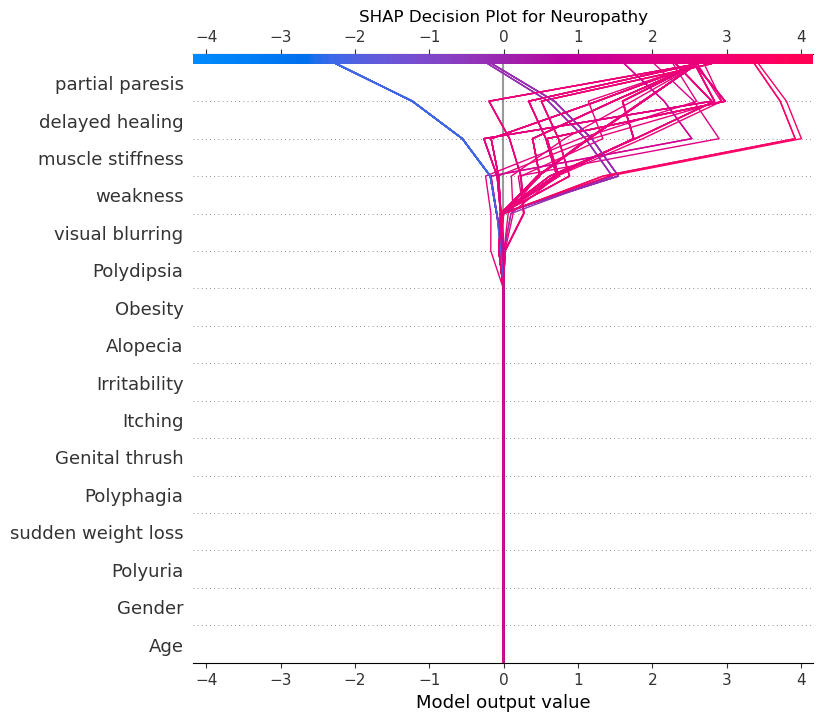

Plotting SHAP values for Nephropathy


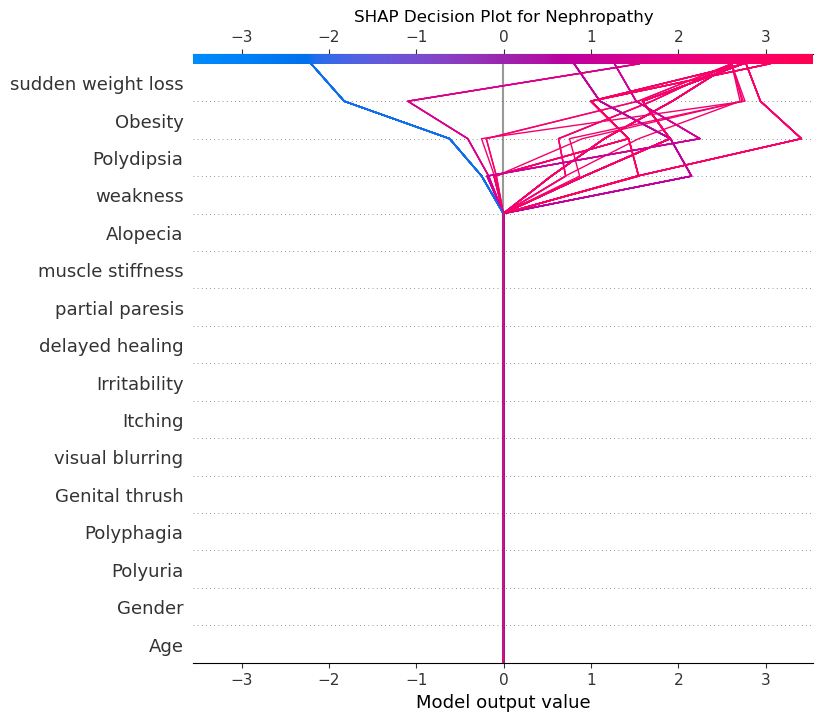

Plotting SHAP values for Ketoacidosis


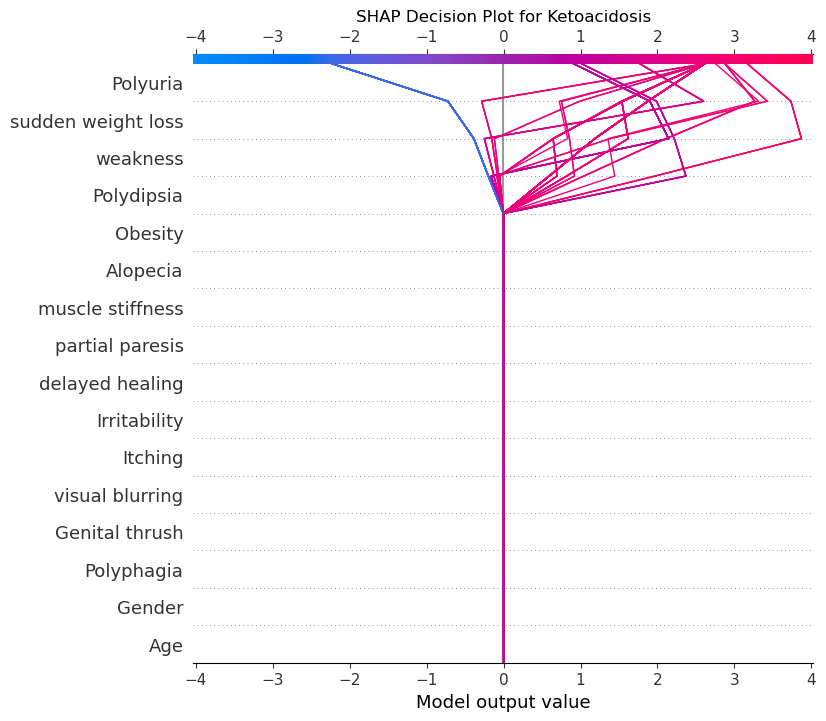

In [178]:
import shap
import pandas as pd

# SHAP JavaScript visualization library
shap.initjs()

X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Target variable names
target_names = ['Neuropathy', 'Nephropathy', 'Ketoacidosis']

shap_values_dict = {}

# Iterate over each classifier in the MultiOutputClassifier
for i, model in enumerate(multi_xgb_best.estimators_):
    explainer = shap.TreeExplainer(model)
    
    shap_values = explainer.shap_values(X_test_df)
    
    # Store SHAP values for the current target
    shap_values_dict[target_names[i]] = shap_values

# Plot SHAP decision plot for the first 100 predictions of each target
for target_name, shap_values in shap_values_dict.items():
    print(f"Plotting SHAP values for {target_name}")
    
    expected_value = explainer.expected_value
    
    # Plot SHAP decision plot
    shap.decision_plot(
        expected_value, 
        shap_values[:100], 
        X_test_df.iloc[:100], 
        feature_names=X_test_df.columns.tolist(),
        title=f"SHAP Decision Plot for {target_name}"
    )

### Saving the Model

In [179]:
import joblib

# Saveing the model to a file
model_filename = 'multi_xgb_best_model.pkl'
joblib.dump(multi_xgb_best, model_filename)

print(f"Model saved to {model_filename}")

Model saved to multi_xgb_best_model.pkl
